# Assignment 3: Determining and removing drawbacks of exponential and running mean

## Team №6:
1. Angelina Prokopeva
2. Nikita Gorbadey
3. Mark Griguletskii
4. Stanislav Savushkin

03.10.2019, Skoltech

## Working progress

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import Image
import os

if not os.path.exists("images"):
    os.mkdir("images")

 **Supplementary function for grapics display**

In [2]:
generate_report = True
def plot(trace_num, x_data, y_data, xlable = 'xlable', ylable = 'ylable',
                legend = 'legend', title = 'title', mode='lines'):
    plot.counter += 1
    fig_name = 'images/' + str(plot.counter) + '.jpg'
    fig = go.Figure()
    for i in range(trace_num):
        fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode=mode, name=legend[i], showlegend = True))
    fig.update_layout(
        title=go.layout.Title(
            text=title,
        ),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
                text=xlable
            )
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
                text=ylable
            )
        )
    )
    if generate_report is True:
        fig.write_image(fig_name)
        display(Image(fig_name))
    else:
        fig.show()
plot.counter = 0

## First part

In [3]:
def exp_smooth_forward(data, alpha, init=0):
    "Supplementary function for forward exponential smoothing"
    out = np.empty(data.size)
    out[0] = init
    for i in range(1, data.size):
        out[i] = out[i-1] + alpha*(data[i]-out[i-1])
    return out

In [4]:
def exp_smooth_backward(data, alpha, init=0):
    "Supplementary function for backward exponential smoothing"
    out = np.empty(data.size)
    out[-1] = init
    for i in reversed(range(data.size-1)):
        out[i] = out[i+1] + alpha*(data[i]-out[i+1])
    return out

In [5]:
def exp_smooth(data, alpha, init=0):
    "Supplementary function for forward then backward exponential smoothing"
    return exp_smooth_backward(exp_smooth_forward(data, alpha, init), alpha, exp_smooth_forward(data, alpha, init)[-1])

In [6]:
def running_mean(data, M):
    "Supplementary function for running mean smoothing"
    out = pd.Series(data).rolling(window = M, center = True).mean()
    out[:int(M/2)+1] = out[int(M/2)]
    out[-int(M/2):] = out[data.size-int(M/2)-1]
    return out

In [7]:
def random_walk_tragectory(init, size, sigma):
    "Supplementary function for generation random walk trajectory"
    out = np.empty(size)
    out[0] = init
    w = np.random.normal(loc=0, scale=sigma, size=size)
    for i in range(1, size):
        out[i] = out[i-1]+w[i]
    return out

In [8]:
def measured_trajectory(data, sigma):
    "Supplementary function for generating measured trajectory"
    return np.add(data, np.random.normal(loc=0, scale=sigma, size=data.size))

**Generating random trajectory with given parameters**

In [9]:
N = 300
sigma_w = 28
sigma_n = 97
num_points = np.linspace(1, N, num=N)
X = random_walk_tragectory(10, N, sigma_w)
z = measured_trajectory(X, sigma_n)

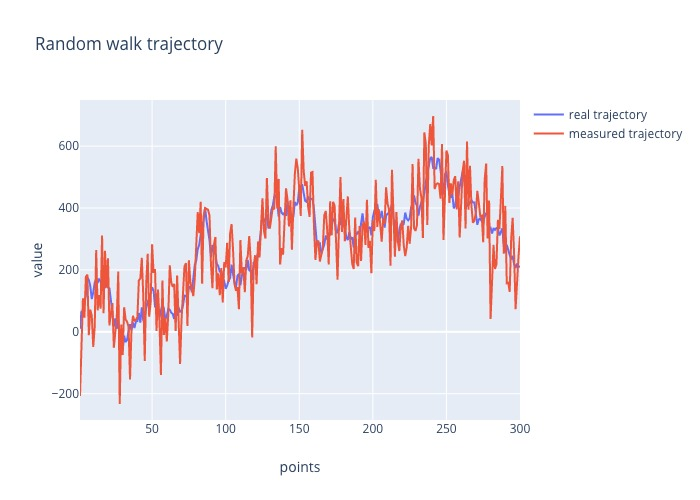

In [10]:
plot(2, [num_points, num_points], [X, z], title='Random walk trajectory', xlable='points', ylable='value',
     legend=['real trajectory', 'measured trajectory'])

**Calculating optimal exponential smoothing parameter**

In [11]:
ksi = sigma_w**2/sigma_n**2
alpha = (-ksi + (ksi**2 + 4*ksi)**0.5)/2
print('Exponential smoothing parameter alpha = {:.2f}'.format(alpha))

Exponential smoothing parameter alpha = 0.25


**Performing forward exponential smoothing**

In [12]:
exp_smooth_for = exp_smooth_forward(z, alpha, z[0])

**Performing backward exponential smoothing for forward smoothed data**

In [13]:
exp_smooth_back = exp_smooth_backward(exp_smooth_for, alpha, exp_smooth_for[-1])

**Performing running mean smoothing with window M equels round((2-alpha)/alpha), so that theoretical variance are equel for both methods**

In [14]:
M = round((2-alpha)/alpha)
run_mean = running_mean(z, M)
print('Running mean window M = {}'.format(M))

Running mean window M = 7


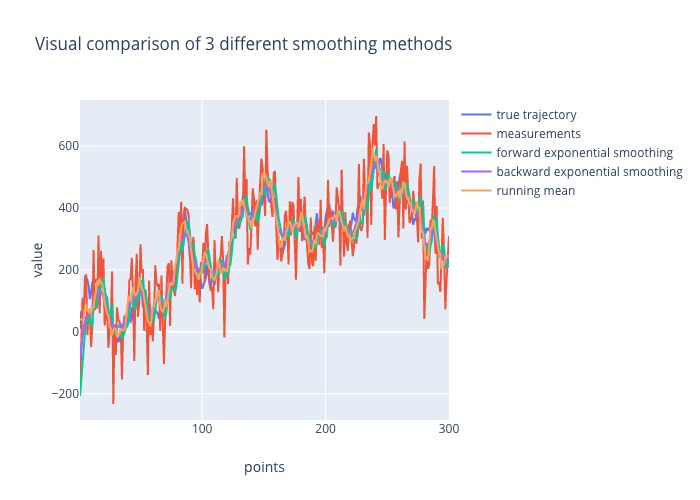

In [15]:
plot(5, [num_points, num_points, num_points, num_points, num_points], 
        [X, z, exp_smooth_for, exp_smooth_back, run_mean],
     legend=['true trajectory', 'measurements', 'forward exponential smoothing',
             'backward exponential smoothing', 'running mean'],
     title='Visual comparison of 3 different smoothing methods', xlable='points', ylable='value')

**From the plot we can see, that forward exponential smoothing method gives significant shift. After applying backward exponential smoothing, the shift almost dissapears. Running mean method provides worse smoothing than backward exponential one**

**Now calculating variances for all methods**

In [16]:
def deviation(X, z):
    "Function for calculating deviation indicator"
    return np.sum((X[:]-z[:])**2)

def variability(X):
    "Function for calculating variability indicator"
    I = np.empty(X.size-2)
    for i in range(X.size-2):
        I[i] = (X[i+2] - 2*X[i+1] + X[i])**2
    return np.sum(I)

**Performing calculation of experimental deviation and variability indicators for real trajectory**

In [17]:
dev_rm = deviation(run_mean, X)
dev_es = deviation(exp_smooth_back, X)
var_rm = variability(run_mean)
var_es = variability(exp_smooth_back)
print(('deviation indicator: running mean                     = {:.2f}\n'+
      '                     backward exponential smoothing   = {:.2f}').format(dev_rm, dev_es))
print(('variability indicator: running mean                   = {:.2f}\n'+
      '                       backward exponential smoothing = {:.2f}').format(var_rm, var_es))


deviation indicator: running mean                     = 477316.62
                     backward exponential smoothing   = 402722.88
variability indicator: running mean                   = 223429.23
                       backward exponential smoothing = 15168.58


**We can observe that running mean deviation indicator is larger than backward exponential, so last provides us with trajectory closer to real one. Meanwhile, backward exponential variability indicator less than running mean one, so the trajectory is more smoothed and it's less responsible to sudden changes**

## Second part

### Drawbacks of running mean method

**First trajectory**

In [18]:
def motion_tragectory(size, T, sigma_a, X_init=0, V_init=0):
    "Function for generating motion trajectory with normally distributed random acceleration"
    out = np.empty(size)
    V = np.empty(size)
    out[0] = X_init
    V[0] = V_init
    a = np.random.normal(loc=0, scale=sigma_a, size=size)
    for i in range(1, size):
        V[i] = V[i-1] + a[i-1]*T
        out[i] = out[i-1] + V[i-1]*T + (a[i-1]*T**2)/2
    return out

**Generating trajectory and its measurements with given parameters**

In [19]:
N = 300
X = motion_tragectory(N, 0.1, np.sqrt(10), X_init=5, V_init=0)
z = measured_trajectory(X, np.sqrt(500))
num_points = np.linspace(1, N, num=N)

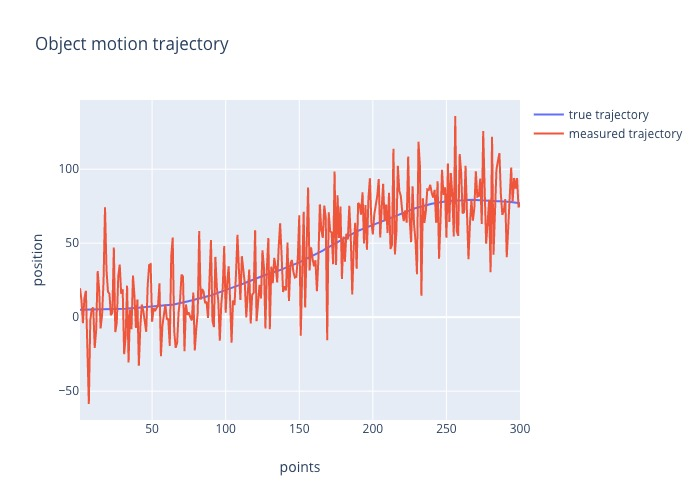

In [20]:
plot(2, [num_points, num_points], [X, z],
     legend=['true trajectory', 'measured trajectory'],
     title='Object motion trajectory', xlable='points', ylable='position')

**To determine optimal window size for running method in this case, we can calculate deviation and viriability indicators for all possible window sizes M**

In [21]:
var_ind = np.zeros(N)
dev_ind = np.zeros(N)
for M in range (2,N):
    run_mean = running_mean(z, M)
    var_ind[M] = variability(run_mean)
    dev_ind[M] = deviation(run_mean, z)

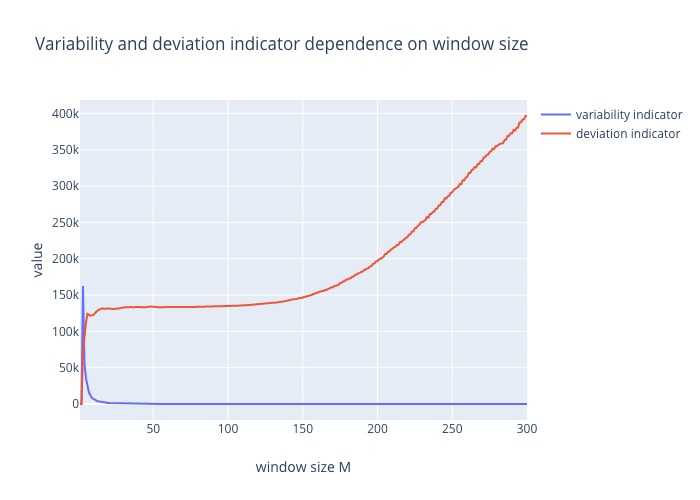

In [22]:
plot(2, [num_points, num_points], [var_ind, dev_ind],
     legend=['variability indicator','deviation indicator'],
     title='Variability and deviation indicator dependence on window size', xlable='window size M',
     ylable='value')

**From the plot we can see, that when window size M = 50 -- 100, the variability indicator is already small and deviation indicator is still not too big. From the common sence, we have the real trajectory which is not very dynamic and measurements with high noize, so it's clear that we should use big window, but still not to big too lose all information**

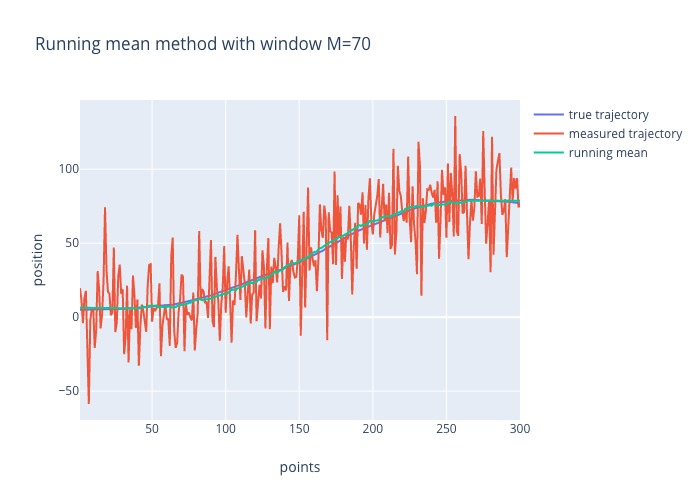

In [23]:
M = 70
plot(3, [num_points, num_points, num_points], [X, z, running_mean(z, M)],
     legend=['true trajectory', 'measured trajectory', 'running mean'], 
     title='Running mean method with window M=70', xlable='points', ylable='position')

**We suggest using window size M = 70 to smooth the data and still keep dynamic observation**

**To determine optimal alpha parameter for exponential smoothing method in this case, we can calculate deviation and viriability indicators for all possible alpha**

In [24]:
var_ind = np.empty(N)
dev_ind = np.empty(N)

# Performing calculation for N=300 alpha from 0 to 1
for i, alpha in enumerate(np.linspace(0, 1, N)):
    exp_sm = exp_smooth(z, alpha)
    var_ind[i] = variability(exp_sm)
    dev_ind[i] = deviation(exp_sm, z)

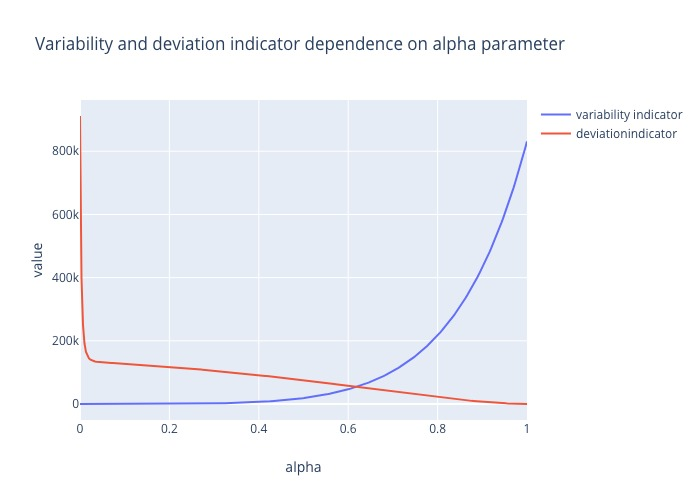

In [25]:
plot(2, [np.linspace(0, 1, N), np.linspace(0, 1, N)], [var_ind, dev_ind],
     legend=['variability indicator', 'deviationindicator'],
     title='Variability and deviation indicator dependence on alpha parameter', xlable='alpha',
     ylable='value')

**From the plot we can see, that when alpha = 0.04 -- 0.08, the variability indicator is still small and deviation indicator is not too big. From the common sence, we have the real trajectory which is not very dynamic and measurements with high noize, so it's clear that we should rely on previous data more than on next measurement, so alpha has to be small**

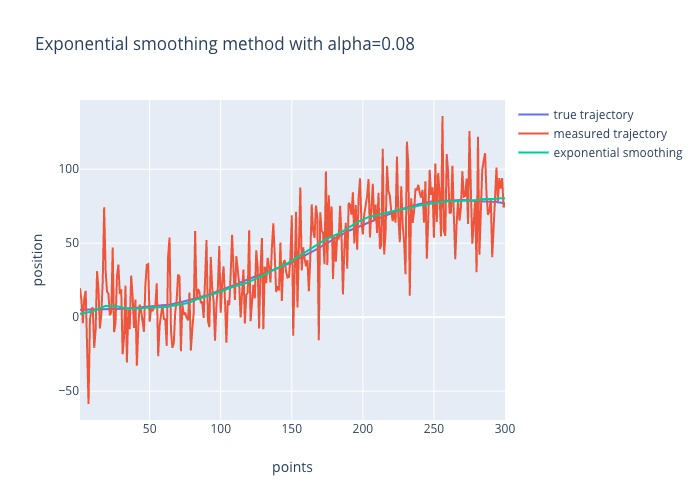

In [26]:
alpha = 0.06
plot(3, [num_points, num_points, num_points], [X, z, exp_smooth(z, alpha)],
     legend=['true trajectory', 'measured trajectory', 'exponential smoothing'], 
     title='Exponential smoothing method with alpha=0.08', xlable='points', ylable='position')

**We suggest using alpha = 0.06 to smooth the data and still keep dynamic observation**

### Second trajectory

In [27]:
def cyclic_trajectory(size, T, sigma, A_init=0):
    "Function for generating true cyclic trajectory with random aplitude"
    A = np.empty(size)
    out = np.empty(size)
    w = np.random.normal(loc=0, scale=sigma, size=size)
    W = 2*np.pi/T
    for i in range(1, size):
        A[i] = A[i-1] + w[i]
        out[i] = A[i] * np.sin(W*i+3)
    return out

**Generating cyclic trajectory, measured trajectory and running mean method with given parameters**

In [28]:
N = 200
M = 13
X = cyclic_trajectory(N, 32, 0.08, A_init=1)
z = measured_trajectory(X, 0.05)
rum_mean = running_mean(z, 13)

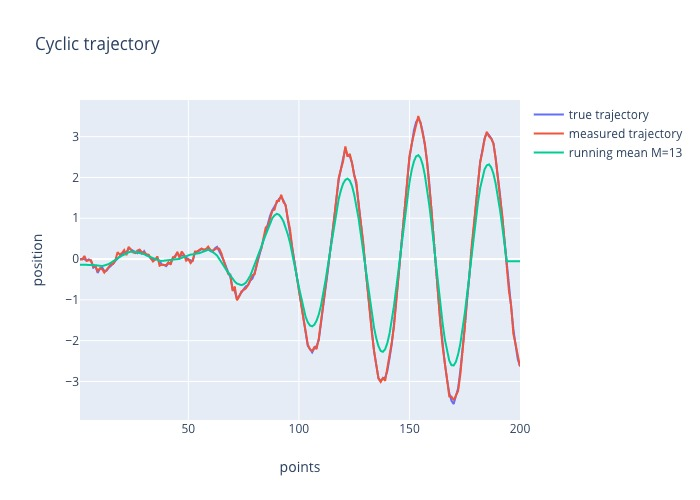

In [29]:
plot(3, [num_points, num_points, num_points], [X, z, rum_mean],
     legend=['true trajectory', 'measured trajectory', 'running mean M=13'],
     title='Cyclic trajectory', xlable='points', ylable='position')

**We can observe inverse oscillation when the period is less than window size:**

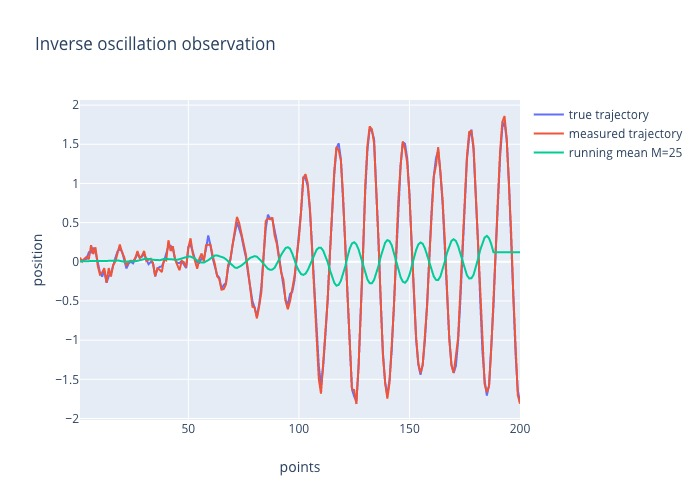

In [30]:
M = 25
N = 200
T = 15
X = cyclic_trajectory(N, T, 0.08, A_init=1)
z = measured_trajectory(X, 0.05)
plot(3, [num_points, num_points, num_points], [X, z, running_mean(z, M)],
     legend=['true trajectory', 'measured trajectory', 'running mean M=25'],
     title='Inverse oscillation observation', xlable='points', ylable='position')

**We can observe the loss of oscillation when the period is about the same as window size:**

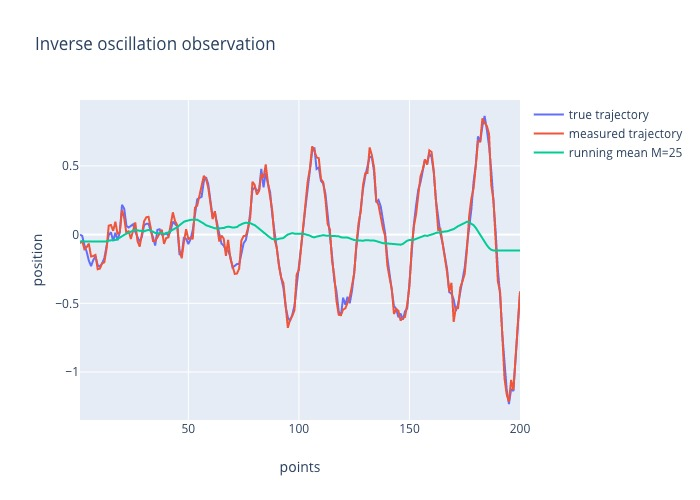

In [31]:
M = 25
N = 200
T = 25
X = cyclic_trajectory(N, T, 0.08, A_init=1)
z = measured_trajectory(X, 0.05)
plot(3, [num_points, num_points, num_points], [X, z, running_mean(z, M)],
     legend=['true trajectory', 'measured trajectory', 'running mean M=25'],
     title='Inverse oscillation observation', xlable='points', ylable='position')

**We can observe the insignificant changes in oscillation when the period is higher window size:**

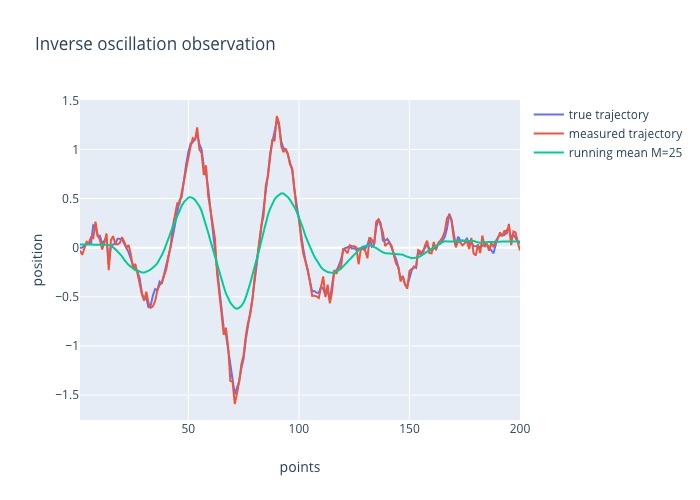

In [32]:
M = 25
N = 200
T = 40
X = cyclic_trajectory(N, T, 0.08, A_init=1)
z = measured_trajectory(X, 0.05)
plot(3, [num_points, num_points, num_points], [X, z, running_mean(z, M)],
     legend=['true trajectory', 'measured trajectory', 'running mean M=25'],
     title='Inverse oscillation observation', xlable='points', ylable='position')

**The conclusion about all these observations is the following: if we chose the window size smaller than period, then the method works correct, as we take mean of samples which are on the same period. If we take window size equals to period, we integrate samples inside one period and we expect mean value for that window about zero. If we take window size bigger than period, than we take mean of samples inside more than one period, generally the result would be unexpected and sometimes leads to inverse oscillations.**

## Conclusion

**We learned in Part I that applying Backward Exponential Smoothing (BES) after Forward Exponential Smoothing removes delay of estimations. 
Also we have studied that BES gives bigger error in sudden changes compared to RS. 
BES has better deviation and variability indicators than Running Smothing (RS). So we can conclude that using BES after FES provides estimates closer to true trajectory, but can lead to information loss.**

**In the second part we learnt the drawback of running mean methods especially for periodical processes.**

**Generally, from this Assignment we learnt that using even such simple smoothing methods as exponential mean and running mean requires deep understanding of these methods and we can't apply them in blind.**